## Predict the skipping behavior of the validation dataset

In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import glob
import dask.dataframe as dd


import lightgbm as lgb
import warnings
warnings.simplefilter("ignore")

import myFunc as mf



tar = tarfile.open('../data/raw/20181120_track_features.tar.gz', 'r:gz')
csv_files = tar.getnames()

tf_df_list = []

for csv_file in [csv_files[2], csv_files[4]]:
    csv_contents = tar.extractfile(csv_file).read()
    tf_df_list.append(pd.read_csv(io.BytesIO(csv_contents), encoding='utf8'))

tf_df = pd.concat(tf_df_list, ignore_index=True)
tf_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)

kmean300_df = pd.read_csv('../data/interim/all_data/mbKMeans300clusters.csv', usecols=['track_id','clus'])
kmean300_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)



In [2]:
# validation data
file_list = ['../data/raw/training_set/log_0_20180918_000000000000.csv']

In [3]:
# the same data processing steps but without weights and track selection

def prep_dfs_eval(file, tf_df, simFolder, kmean_df):
    log_df = pd.read_csv(file)
    log_df = log_df.merge(kmean_df)

    log_df_1 = log_df.loc[log_df['session_position']<=(log_df['session_length']/2)]
    log_df_1['hour_of_day'] = log_df_1['hour_of_day'].astype('float')
    log_df_1['premium'] = log_df_1['premium'].astype('bool')
    log_df_1 = log_df_1.drop(columns = ['date'])
    log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type'], dtype = 'bool')
    log_df_1 = log_df_1.merge(tf_df.drop(columns = ['time_signature','mode','key']))
    
                     
    col_bool = log_df_1.columns[log_df_1.dtypes=='bool']
    col_nonbool = log_df_1.columns[log_df_1.dtypes!='bool'].drop(['session_id','track_id_clean','clus'])
    
    # the non-convertable values will be set to 0
    log_df_1[col_nonbool] = log_df_1[col_nonbool].apply(pd.to_numeric, errors='coerce', downcast = 'float').fillna(0).astype('float32')

    # aggregate the track history where ['skip_2']==True
    log_df_1_summary_skip2True = pd.concat([log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_bool].agg(['mean']), 
                                            log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                            axis = 1)
    log_df_1_summary_skip2True.columns = log_df_1_summary_skip2True.columns.get_level_values(0)+'_sk2True_'+log_df_1_summary_skip2True.columns.get_level_values(1)
    
    # aggregate the track history where ['skip_2']==False
    log_df_1_summary_skip2False = pd.concat([log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_bool].agg(['mean']), 
                                             log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                             axis = 1)
    log_df_1_summary_skip2False.columns = log_df_1_summary_skip2False.columns.get_level_values(0)+'_sk2False_'+log_df_1_summary_skip2False.columns.get_level_values(1)
    
    
    log_df_history = log_df_1[['session_id','track_id_clean','skip_2','clus']]


    half_cut = log_df['session_length']/2


    log_df_2 = log_df.loc[(log_df['session_position']>half_cut)]
    log_df_2 = log_df_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2True, on='session_id')
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2False, on='session_id')
    

    sim_file_list = ['../models/SVD/all_tracks/'+simFolder+'/k300_CanbDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_CosSim.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_LinCorr.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_ManhDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_HammDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_SpearCorr.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_KendCorr.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_ChebDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_BrayDist.csv']
    score_name_list = ['CanbDist300', 'CosSim300','LinCorr300','ManhDist300','HammDist300','SpearCorr300','KendCorr300','ChebDist','BrayDist']

    return mf.get_sim(log_df_history, log_df_2, sim_file_list, score_name_list)

In [4]:
# predict the skipping behavior based on the fitted model

from timeit import default_timer as timer #to see how long the computation will take

ap_list = []
first_pred_acc_list = []

simFolder_list = ['similarity_20180917-20180917',
                  'similarity_20180916-20180917',
                  'similarity_20180915-20180917']


for (nFile, simFolder) in zip([10,20,30], simFolder_list):
    model_filename = '../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_alltracks_incrementalTrain_'+str(int(nFile))+'_multidays_jan14.txt'

    df_lookup_list = []
    for file in file_list[0:1]:
        start = timer()
        df_lookup_list.append(prep_dfs_eval(file, tf_df, simFolder, kmean300_df))

    df_lookup = pd.concat(df_lookup_list)
    df_lookup = df_lookup.merge(tf_df.drop(columns = ['key','time_signature','mode']))
    
    
    prev_feature_names = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_alltracks_incrementalTrain_5_multidays_jan14.txt').feature_name()
    if bool(set(prev_feature_names) - set(df_lookup.columns)): # if there are missing columns
        df_lookup[list(set(prev_feature_names) - set(df_lookup.columns))] = 0 # add the missed columns with 0

    if bool(set(df_lookup.columns)- set(prev_feature_names)): # if there are extra columns
        extra_cols = list(set(df_lookup.columns)- set(prev_feature_names) - set(['session_id','track_id_clean','skip_2','weight']))
        df_lookup.drop(columns = extra_cols, inplace = True)
            

    df_lookup.sort_values(['session_id','session_position'], inplace = True)
    df_test = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).astype('float32')
    X = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).to_numpy()

    # As it is too slow to calculate the AP of all the sessions in a file. I picked the first 10000 tracks as the validation dataset.
    s_list = df_lookup['session_id'].unique()[0:10000]
    sel_row = df_lookup['session_id'].isin(s_list)
    ytrue = df_lookup['skip_2']
    
    # check whether the column names match with the previous training set
    prev_feature_names = lgb.Booster(model_file=model_filename).feature_name()
    if bool(set(prev_feature_names) - set(df_lookup.columns)): # if there are missing columns
                df_lookup[list(set(prev_feature_names) - set(df_lookup.columns))] = 0 # add the missed columns with 0

    if bool(set(df_lookup.columns)- set(prev_feature_names)): # if there are extra columns
        extra_cols = list(set(df_lookup.columns)- set(prev_feature_names) - set(['session_id','track_id_clean','skip_2','weight']))
        df_lookup.drop(columns = extra_cols, inplace = True)

    bst = lgb.Booster(model_file=model_filename)  # init model

    ypred = bst.predict(X)
    print('Runtime per batch: %0.2fs' % (timer() - start))

    
    ap,first_pred_acc  = mf.spotify_eval(ytrue[sel_row], ypred[sel_row]>0.5, df_lookup.loc[sel_row])
    ap_list.append(ap)
    first_pred_acc_list.append(first_pred_acc)
    

Runtime per batch: 86.47s
Runtime per batch: 110.02s
Runtime per batch: 134.71s


In [5]:
# results = pd.DataFrame({'ap': ap_list, 'first_pred_acc': first_pred_acc_list, 'days':[1,2,3,4,5,6,7]})
results = pd.DataFrame({'ap': ap_list, 'first_pred_acc': first_pred_acc_list, 'days':[1,2,3]})

results

,ap,first_pred_acc,days
0,0.570301,0.7439,1
1,0.480130,0.6406,2
2,0.418117,0.5566,3


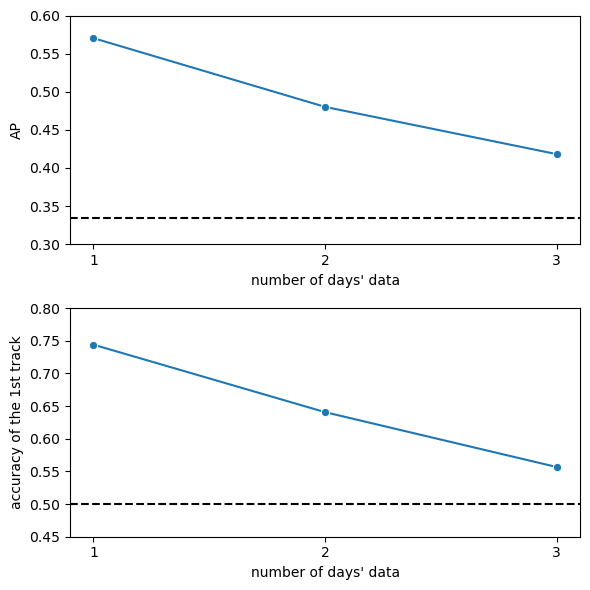

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(figsize=(6,6), nrows=2) 

graph1 = sns.lineplot(y='ap', x='days', data=results, ax=ax1, hue=True, style = True, markers = True, legend = False)
ax1.set_xticks([1,2,3])
ax1.set_ylabel('AP')
ax1.set_xlabel("number of days' data")
graph1.axhline(0.334, linestyle = '--', c = 'k')
ax1.set_ylim(0.3,0.6)

graph2 = sns.lineplot(y='first_pred_acc', x='days', data=results, ax=ax2, hue=True, style = True, markers = True, legend = False)
ax2.set_xticks([1,2,3])
ax2.set_ylabel('accuracy of the 1st track')
ax2.set_xlabel("number of days' data")
graph2.axhline(0.5, linestyle = '--', c = 'k')
ax2.set_ylim(0.45,0.8)
plt.tight_layout()

plt.show()

Althought all the model performances were above the baselines, it was clear that the prediction performance was the best when only including the training data from 1 day before. 

The performance dropped significantly when the training data spanned to 2 or 3 days before. The performances went up again and stayed at a plateau after adding more data, but not as good as 1 day training data only.

To be honest, it was a weird pattern!!

A possible explanation is that the information from the days further away are more different to the validation dataset. Therefore, adding 2 or 3 days' of data before the validation dataset into the model was like adding noise. This situation could be mitigated when adding sufficient amount of old data, as some subtle patterns might emerge with sufficient amount of "noise". However, as the model capacity was limited to further encode any more subtle patterns beyond the 4 days of data, the prediction performance reached its plateau.